# Efficient handling of invalid simulation outputs

For many simulators, the output of the simulator can be ill-defined or it can have non-sensical values. For example, in neuroscience models, if a specific parameter set does not produce a spike, features such as the spike shape can not be computed. When using `sbi`, such simulations that have `NaN` or `inf` in their output are discarded during neural network training. This can lead to inefficetive use of simulation budget: we carry out many simulations, but a potentially large fraction of them is discarded. 

In this tutorial, we show how we can use `sbi` to learn regions in parameter space that produce `valid` simulation outputs, and thereby improve the sampling efficiency. The key idea of the method is to use a classifier to distinguish parameters that lead to `valid` simulations from regions that lead to `invalid` simulations. After we have obtained the region in parameter space that produes `valid` simulation outputs, we train the deep neural density estimator used in `SNPE`. The method was originally proposed in [Lueckmann, Goncalves et al. 2017](https://arxiv.org/abs/1711.01861) and later used in [Deistler et al. 2021](https://www.biorxiv.org/content/10.1101/2021.07.30.454484v3.abstract).

## Main syntax

In [ ]:
from sbi.inference import SNPE
from sbi.utils import RestrictionEstimator

restriction_estimator = RestrictionEstimator(prior=prior)
proposals = [prior]

for r in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposals[-1], 1000)
    restriction_estimator.append_simulations(theta, x)
    if r < num_rounds - 1: # training not needed in last round because classifier will not be used anymore.
        classifier = restriction_estimator.train()
    proposals.append(restriction_estimator.restrict_prior())

all_theta, all_x, _ = restriction_estimator.get_simulations()

inference = SNPE(prior=prior)
density_estimator = inference.append_simulations(all_theta, all_x).train()
posterior = inference.build_posterior()

## Further explanation in a toy example

In [1]:
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils import RestrictionEstimator, BoxUniform
from sbi.analysis import pairplot
import torch

_ = torch.manual_seed(2)

We will define a simulator with two parameters and two simulation outputs. The simulator produces `NaN` whenever the first parameter is below `0.0`. If it is above `0.0` the simulator simply perturbs the parameter set with Gaussian noise:

In [2]:
def simulator(theta):
    perturbed_theta = theta + 0.5 * torch.randn(2)
    perturbed_theta[theta[:, 0] < 0.0] = torch.as_tensor([float("nan"), float("nan")])
    return perturbed_theta

The prior is a uniform distribution in [-2, 2]:

In [3]:
prior = BoxUniform(-2*torch.ones(2), 2*torch.ones(2))

We then begin by drawing samples from the prior and simulating them. Looking at the simulation outputs, half of them contain `NaN`:

In [4]:
theta, x = simulate_for_sbi(simulator, prior, 1000)
print("Simulation outputs: ", x)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation outputs:  tensor([[ 0.0411, -0.5656],
        [ 0.0096, -1.0841],
        [ 1.2937,  0.9448],
        ...,
        [    nan,     nan],
        [    nan,     nan],
        [ 2.7940,  0.6461]])


The simulations that contain `NaN` are wasted, and we want to learn to "restrict" the prior such that it produces only `valid` simulation outputs. To do so, we set up the `RestrictionEstimator`:

In [5]:
restriction_estimator = RestrictionEstimator(prior=prior)

The `RestrictionEstimator` trains a classifier to distinguish parameters that lead to `valid` simulation outputs from parameters that lead to `invalid` simulation outputs 

In [6]:
restriction_estimator.append_simulations(theta, x)
classifier = restriction_estimator.train()

We can inspect the `restricted_prior`, i.e. the parameters that the classifier believes will lead to `valid` simulation outputs, with:

The classifier rejected 51.6% of all samples. You will get a speed-up of 106.5%.


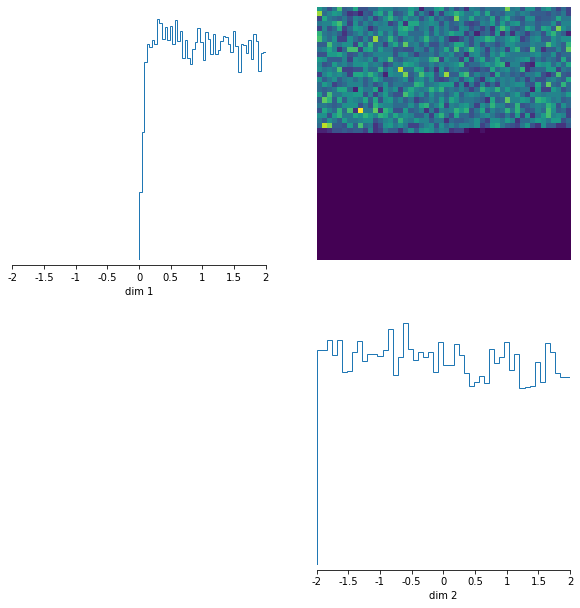

In [7]:
restricted_prior = restriction_estimator.restrict_prior()
samples = restricted_prior.sample((10_000,))
_ = pairplot(samples, limits=[[-2, 2], [-2, 2]], fig_size=(4, 4))

Indeed, parameter sets sampled from the `restricted_prior` always have a first parameter larger than `0.0`. These are the ones that produce `valid` simulation outputs (see our definition of the simulator above). We can then use the `restricted_prior` to generate more simulations. Almost all of them will have `valid` simulation outputs:

In [8]:
new_theta, new_x = simulate_for_sbi(simulator, restricted_prior, 1000)
print("Simulation outputs: ", new_x)

The classifier rejected 50.9% of all samples. You will get a speed-up of 103.6%.


Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Simulation outputs:  tensor([[ 0.6834, -0.2415],
        [ 1.3459,  1.5373],
        [ 2.1092,  1.9180],
        ...,
        [ 0.8845,  0.4036],
        [ 1.9111,  1.2526],
        [ 0.8320,  2.3755]])


We can now use **all** simulations and run `SNPE` as always:

 Neural network successfully converged after 118 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

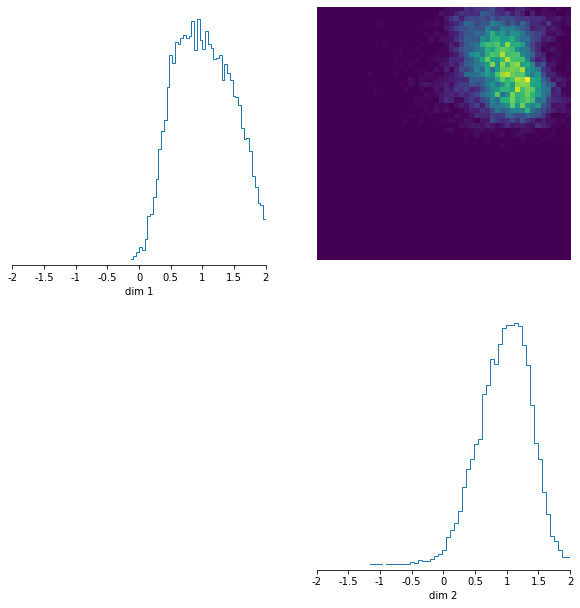

In [9]:
restriction_estimator.append_simulations(new_theta, new_x)  # Gather the new simulations in the `restriction_estimator`.
all_theta, all_x, _ = restriction_estimator.get_simulations()  # Get all simulations run so far.

inference = SNPE(prior=prior)
density_estimator = inference.append_simulations(all_theta, all_x).train()
posterior = inference.build_posterior()

posterior_samples = posterior.sample((10_000,), x=torch.ones(2))
_ = pairplot(posterior_samples, limits=[[-2, 2], [-2, 2]], fig_size=(3, 3))

## Further options for tuning the algorithm

- the whole procedure can be repeated many times (see the loop shown in "Main syntax" in this tutorial)  
- the classifier is trained to be relatively conservative, i.e. it will try to be very sure that a specific parameter set can indeed not produce `valid` simulation outputs. If you are ok with the restricted prior potentially ignoring a small fraction of parameter sets that might have produced `valid` data, you can use `restriction_estimator.restrict_prior(allowed_false_negatives=...)`. The argument `allowed_false_negatives` sets the fraction of potentially ignored parameter sets. A higher value will lead to more `valid` simulations.  
- By default, the algorithm considers simulations that have at least one `NaN` of `inf` as `invalid`. You can specify custom criterions with `RestrictionEstimator(decision_criterion=...)`